<H3> Init </H3>

In [166]:
%reload_ext autoreload
%autoreload 2
#ignore warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<H3> Imports and Constants </H3>

In [167]:
#imports
import pandas as pd
import numpy as np
import os, sys, itertools as it, random
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss, roc_curve, brier_score_loss

#constants
mu = 0
sigma = 1

#path
sys.path.append('../modules')

<H3> File Configurations </H3>

In [168]:
def load_configurations():
    #configurations of prediction file [column header, format, range etc.]
    c_p={
            'dir': '../newdata/predictions/',
            'file': 'prediction_shift_0.csv',
            'number_of_samples': 500, #don't bother about this, this is just used while generating synthetic data
            'id_column': 'person_id',
            'id_format': int,
            'date_column': 'Date',
            'date_format': 'datetime', #options: 'ym', 'y-m-d', datetime
            'start_date': '2016-01-01', #first month is January 2016
            'end_date': '2018-01-01', #last month is December 2017
            'model_columns': ['lin_reg', 'rand_forest', 'xg_boost', 'sgmm'],
            'model_format': int
        }

    #configurations of referral file [column header, format, range etc.]
    c_r={
            'dir': '../newdata/referrals/',
            'file': 'referral.csv',
            'number_of_samples': 25, #don't bother about this, this is just used while generating synthetic data
            'start_date': '2016-01-01',
            'end_date': '2018-01-01',
            'id_column': 'person_id',
            'id_format': int,
            'date_column': 'Date',
            'date_format': 'datetime', #options: 'ym', 'y-m-d', datetime
            'day_to_evaluate': 1 #evaluate on day 1 of each month
        }
    
    #configurations for the experiment
    c_e={
            'experiment': 'Version 1.0',
            'dir': '../newdata/results/',
            'file': 'results.csv',
            'thresholding': [0.5, 0.6],
            'top_k': [50, 60],
            'window': [[0,3], [-3,6], [0,12]],
            'eval_date': pd.to_datetime(dt.date(2017,1,1)),
            'eval_method': 'top_k' #options: 'top_k' or 'thresholding'
        }
    
    return c_p, c_r, c_e

<H3> HELPER FUNCTIONS </H3>

In [169]:
#generate random date between a range
#input in datetime.date format
def generate_random_date(start_date, end_date, iteration, date_format):
    date_list = []
    seed = 0
    for i in range(iteration):
        s_date = datetime.strptime(start_date, '%Y-%m-%d')
        e_date = datetime.strptime(end_date, '%Y-%m-%d')
        time_between_dates = e_date - s_date
        days_between_dates = time_between_dates.days
        random.seed(seed)
        random_number_of_days = random.randrange(days_between_dates)
        random_date = s_date + dt.timedelta(days=random_number_of_days) #this is datetime object
        if date_format=='y-m-d':
            random_date = random_date.strftime('%Y-%m-%d') #string format output
        elif date_format=='ym':
            random_date = int(random_date.strftime("%Y%m"))
        date_list.append(random_date)
        seed += 1
    
    return date_list
    

In [170]:
#preprocess referral dates
#convert any day in any month to the first day of that month in REFERRAL data
def convert_dates_ref(ref_copy, c_r): #use if c_r['date_format'] is 'y-m-d' or datetime
    ref_date_column = ref_copy[c_r['date_column']]
    for i in range(len(ref_date_column)):
        formatted_date = ref_date_column[i]
        new_formatted_date = datetime(formatted_date.year, formatted_date.month, c_r['day_to_evaluate'])
        ref_copy.at[i,c_r['date_column']] = new_formatted_date

    return ref_copy
    
    
    
#     ref_date_column = ref_copy[c_r['date_column']]
#     for i in range(len(ref_date_column)):
#         if c_r['date_format']=='y-m-d': #string
#             formatted_date = datetime.strptime(ref_date_column[i], '%Y-%m-%d') #string to datetime
#             new_formatted_date = datetime(formatted_date.year, formatted_date.month, c_r['day_to_evaluate']).strftime('%Y-%m-%d')
#         elif c_r['date_format']=='datetime':
#             formatted_date = ref_date_column[i]
#             print("In Convert dates ref", type(ref_date_column[i]))
#             new_formatted_date = datetime(formatted_date.year, formatted_date.month, c_r['day_to_evaluate'])
#         ref_copy.at[i,c_r['date_column']] = new_formatted_date
#     return ref_copy #returns date in same format
        
    

In [171]:
#convert top k probability of a target to 1, O/W to 0 mapping
def prob_to_bin(target, k):
    ind=np.argpartition(target, -k)[-k:]
    target_bin=np.zeros(len(target))
    target_bin[ind]=1
    return target_bin

In [172]:
#data = dataframe, file='/relative_path/to/file'
def dataframe_to_csv(data, file, append=False, index=False, num_samples=np.NaN):
    if append and os.path.exists(file):
        data.to_csv(file, index=index, float_format= '%8.5f', mode='a')
    else:
        data.to_csv(file, index=index, float_format= '%8.5f')

In [173]:
#give e 'ym' column, it will convert all of them to 'ymd'
#pd.to_Datetime(anything) = create datetime object
#datetime.strptime(string) -> datetime object
#datetime.strftime(datetime) -> string in different formats
def ym_to_datetime(config, df): #ym to datetime
    label = config['date_column']
    df[label] = df[label].astype(str)
    for i in range(df[label].size):
        df[label][i] = df[label][i][:4] + '-' + df[label][i][4:] + '-01' #choosing the first month of the day
    df[label] = pd.to_datetime(df[label])
    return df
    

<H3> Generate Synthetic Data </H3>

In [174]:
def generate_synthetic_ground_truth_data(c_p, c_r):
    seed = 0
    np.random.seed(seed)
    patients = pd.Series([x for x in np.random.randint(0, c_p['number_of_samples']*2, c_r['number_of_samples'])])
    patients = patients.sort_values(ascending=True).reset_index(drop=True)
    date = pd.Series([d for d in generate_random_date(c_r['start_date'], c_r['end_date'], c_r['number_of_samples'], c_r['date_format'])])
    data = pd.DataFrame({c_r['id_column']:patients, c_r['date_column']:date})
    dataframe_to_csv(data, c_r['dir']+c_r['file'])


In [175]:

def generate_synthetic_prediction_data(c_p):
    patients = pd.Series(range(0, c_p['number_of_samples'])) #500
    
    if c_p['date_format']=='ym':
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS').strftime("%Y%m").astype(int) #25
    elif c_p['date_format']=='y-m-d':
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS').strftime("%Y-%m-%d")
    else:
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS')
    
    data = pd.DataFrame(list(it.product(patients,date)),columns=[c_p['id_column'],c_p['date_column']])
    seed = 0
    for model in c_p['model_columns']:
        np.random.seed(seed)
        data[model] = pd.Series(np.random.random((data.shape[0])))
        seed+=1
    dataframe_to_csv(data, c_p['dir']+c_p['file'])

<H3> Score Class </H3>

In [176]:
class Score:
    
    def __init__(self, model_name):
        self.model_name = model_name
        self.precision = {}
        self.recall = {}
        self.accuracy = {}
        self.balanced_accuracy = {}
        self.f1_score = {}
        self.roc_auc_score = {} 
        self.log_loss = {}
        self.brier_score_loss = {}
    
    def get_precision(self, y_true, y_predict, average='binary'):
        return precision_score(y_true, y_predict, average)
    
    def get_recall(self, y_true, y_predict, average='binary'):
        return recall_score(y_true, y_predict, average)
    
    def get_accuracy(self, y_true, y_predict):
        return recall_score(y_true, y_predict)
    
    def get_balanced_accuracy(self, y_true, y_predict):
        return balanced_accuracy_score(y_true, y_predict)
    
    def get_f1_score(self, y_true, y_predict, average='binary'):
        return f1_score(y_true, y_predict, average='binary')
    
    def get_roc_auc_score(self, y_true, y_predict):
        return roc_auc_score(y_true, y_predict)
    
    def get_log_loss(self, y_true, y_predict):
        return log_loss(y_true, y_predict)
    #-----------------------------------------------------
    #need to implement
    #prob_from_a_model = [0.8, 0.3, 0.5]
    #ground_truth_binary = [1,0,0]
    #briar score(ground_truth_binary, prob_from_a_model)
    def get_brier_score_loss(self, y_true, y_predict):
        return brier_score_loss(y_true, y_predict)
    
        

<H3> Evaluation </H3>

In [177]:
def evaluate(c_p, c_r, c_e):
    
    eval_method = c_e['eval_method']      
    
    referral = pd.read_csv(c_r['dir'] + c_r['file'])
    ref_copy = referral.copy()
    
    #convert_dates_ref(c_r)
    if c_r['date_format']=='ym':
        ref_copy = ym_to_datetime(c_r, ref_copy) #datetime
    else:
        ref_copy[c_r['date_column']] = pd.to_datetime(ref_copy[c_r['date_column']])
        ref_copy = convert_dates_ref(ref_copy, c_r)
    
    ref_copy['target'] = pd.Series(np.ones(c_r['number_of_samples'], dtype=float))
    ref_copy = ref_copy.pivot_table(index=c_r['id_column'], columns=c_r['date_column'], values='target', aggfunc='sum')
    ref_copy = ref_copy.fillna(0)

    #now both pred_copy['Date'] and ref_copy['Date'] is in Datetime format instead of previous String format
    
    prediction = pd.read_csv(c_p['dir'] + c_p['file'])
    pred_copy = prediction.copy()
        
    #change date from ym to ymd here
    if c_p['date_format']=='ym':
        pred_copy = ym_to_datetime(c_p, prediction) #datetime
    else:
        pred_copy[c_p['date_column']] = pd.to_datetime(pred_copy[c_p['date_column']])
        
    #now both ref_copy and pred_copy are datetime
    
    pred_copy = pred_copy.loc[pred_copy[c_p['date_column']]==c_e['eval_date']]
    
    display(pred_copy)
    
    all_model_evaluations = {} #{'model_name':score class object for that model}
    
    #now branch out for each model
    for model in c_p['model_columns']:
        
        evaluated_model_obj = Score(model)
        
        #calculate for each window
        for window in c_e['window']:
            
            #taking negative window into consideration
            if(window[0]<0):
                start = c_e['eval_date'] - pd.DateOffset(months=(-1)*window[0])
            else:
                start = c_e['eval_date'] + pd.DateOffset(months=window[0])
                
            end = c_e['eval_date'] + pd.DateOffset(months=window[1])
            
            sl=slice(start,end)
            y_true = ref_copy.loc[:,sl]
            y_true = y_true.sum(axis=1)
            
            #for the time being, all ref patients are in pred_list. 
            #Change random.randint upper_range in data_generate to tweak
            y_true=y_true[y_true.index.isin(pred_copy[c_p['id_column']])]
            
            y_true=y_true.append(pd.Series(0,index=set(pred_copy[c_p['id_column']])-set(y_true.index))).sort_index()
        
            #their size have to be same -- TO USE the built in metric functions
            if pred_copy.shape[0]!=len(y_true):
                print("ERROR: PREDICTION AND ACTUAL DATAFRAME HAVE DIFFERENT NUMBERS.  PREDICTION:",pred_copy.shape[0], " EVALUATION: ",len(y_true))
                break
            
            #now thresholding method
            if eval_method=='top_k':
                for k_values in c_e['top_k']:
                    label = model+'_window_['+str(window[0])+','+str(window[1])+']_'+eval_method + '_@' + str(k_values)
                    pred_copy[label] = prob_to_bin(pred_copy[model], k_values)
                    #model score for this (window,k) update
                    update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
    
            elif eval_method == 'thresholding':
                for thresholds in c_e['thresholding']:
                    label = model+'_window_['+str(window[0])+','+str(window[1])+']_'+eval_method + '_@' + str(thresholds)
                    pred_copy[label] = np.where(pred_copy[model] > thresholds, 1, 0)
                    #model score for this (window,threshold) update
                    update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
            
        all_model_evaluations.update({model:evaluated_model_obj})
    
    #add the number of samples all experiments were conducted on at the end of the evaluation dictionary
    all_model_evaluations.update({'number_of_experimental_samples': y_true.shape[0]})
    
    return all_model_evaluations

In [178]:
def update_model_score(model, evaluated_model_obj, label, y_true, pred_copy):
    
    precision = evaluated_model_obj.get_precision(y_true.values, pred_copy[label].values)
    evaluated_model_obj.precision.update({label:precision})

    recall = evaluated_model_obj.get_recall(y_true.values, pred_copy[label].values)
    evaluated_model_obj.recall.update({label:recall})

    accuracy = evaluated_model_obj.get_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.accuracy.update({label:accuracy})

    balanced_accuracy = evaluated_model_obj.get_balanced_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.balanced_accuracy.update({label:balanced_accuracy})

    f1_score = evaluated_model_obj.get_f1_score(y_true.values, pred_copy[label].values)
    evaluated_model_obj.f1_score.update({label:f1_score})

    #these will take predicted probabilites, not thresholded binaries

    log_loss = evaluated_model_obj.get_log_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.log_loss.update({label:log_loss})

    roc_auc_score = evaluated_model_obj.get_roc_auc_score(y_true.values, pred_copy[model].values)
    evaluated_model_obj.roc_auc_score.update({label:roc_auc_score})
    
    brier_score_loss = evaluated_model_obj.get_brier_score_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.brier_score_loss.update({label:brier_score_loss})
    
    

<H3> Present Evaluation </H3>

In [179]:
def evaluation_to_dataframe(model_name, model_score):
    #all dictionaries with different windows
    precision = model_score.precision
    recall = model_score.recall
    accuracy = model_score.accuracy
    balanced_accuracy = model_score.balanced_accuracy
    f1_score = model_score.f1_score
    log_loss = model_score.log_loss
    roc_auc_score = model_score.roc_auc_score
    brier_score_loss = model_score.brier_score_loss
    
    metric_name = ['precision', 'recall', 'accuracy', 'balanced_accuracy', 'f1_score', 'log_loss', 'roc_auc_score', 'brier_score_loss']
    metric_value = [precision, recall, accuracy, balanced_accuracy, f1_score, log_loss, roc_auc_score, brier_score_loss]
    
    data = pd.DataFrame(metric_value, index=metric_name)
    
    return data
    

In [180]:
#takes dataframe as input. Displays and plots it.
def visualize_result(data, table=False, plot=False):
    if display:
        pd.options.display.float_format = '{:10.5f}'.format
        display(data)
    if plot:
        data.plot.bar(figsize=(12,6))
        plt.show()

In [181]:
#generate plottable dataframe from whole result: evaluation_to_dataframe() helper function
#visualize result (if visual==True): visualize_performance() helper_function
#save result to CSV file: Use dataframe_to_csv() helper function
def present_evaluation(c_e, all_model_evaluations, visual=False, save=False):
    
    #result file
    result_file = c_e['dir']+c_e['file']
    
    #number of samples extract and drop from dictionary
    number_of_experimental_samples = all_model_evaluations['number_of_experimental_samples']
    del all_model_evaluations['number_of_experimental_samples']
    
    #clear if there is already any result file previously (from previous run/experiment), 
    #otherwise it will just keep appending, as opening in append mode
    if os.path.exists(result_file):
        os.remove(result_file)
    
    #run everything
    for model_name in all_model_evaluations:
        data = evaluation_to_dataframe(model_name, all_model_evaluations[model_name])
        if visual==True:
            visualize_result(data, table=True, plot=True)
        if save==True:
            print("Number of Experimental Samples: ", number_of_experimental_samples)
            dataframe_to_csv(data, result_file, append=True, index=True, num_samples=number_of_experimental_samples)
    
    

<H2> MAIN </H2>

<class 'pandas.core.series.Series'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2017-01-01 00:00:00


,person_id,Date,lin_reg,rand_forest,xg_boost,sgmm
12,0,2017-01-01,0.56804,0.20445,0.13458,0.64914
37,1,2017-01-01,0.61693,0.83463,0.58000,0.55784
62,2,2017-01-01,0.65633,0.69440,0.76496,0.33985
87,3,2017-01-01,0.09394,0.96484,0.55098,0.26389
112,4,2017-01-01,0.69948,0.93260,0.41974,0.21799
...,...,...,...,...,...,...
12387,495,2017-01-01,0.39179,0.20014,0.55524,0.35655
12412,496,2017-01-01,0.59465,0.21691,0.20112,0.54969
12437,497,2017-01-01,0.09675,0.48642,0.35892,0.15154
12462,498,2017-01-01,0.30789,0.62379,0.60613,0.16164


,"lin_reg_window_[0,3]_top_k_@50","lin_reg_window_[0,3]_top_k_@60","lin_reg_window_[-3,6]_top_k_@50","lin_reg_window_[-3,6]_top_k_@60","lin_reg_window_[0,12]_top_k_@50","lin_reg_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
recall,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
accuracy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
balanced_accuracy,0.44980,0.43976,0.44970,0.43964,0.44949,0.43939
f1_score,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
log_loss,0.96216,0.96216,0.96239,0.96239,0.97112,0.97112
roc_auc_score,0.47490,0.47490,0.48826,0.48826,0.30949,0.30949
brier_score_loss,0.32014,0.32014,0.32026,0.32026,0.32382,0.32382


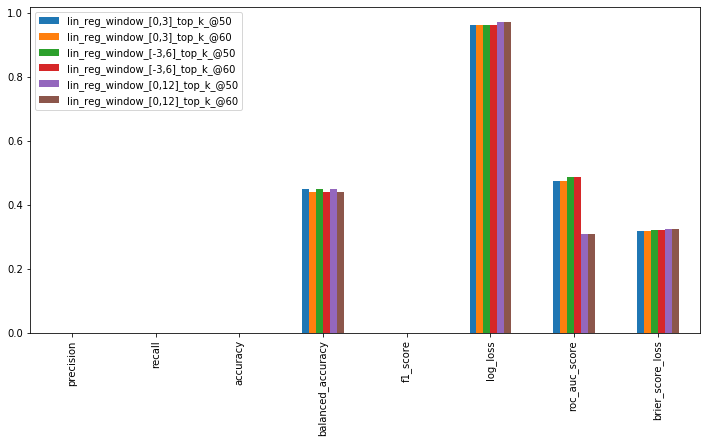

Number of Experimental Samples:  500


,"rand_forest_window_[0,3]_top_k_@50","rand_forest_window_[0,3]_top_k_@60","rand_forest_window_[-3,6]_top_k_@50","rand_forest_window_[-3,6]_top_k_@60","rand_forest_window_[0,12]_top_k_@50","rand_forest_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.02000,0.01667,0.00000,0.00000
recall,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000
accuracy,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000
balanced_accuracy,0.44980,0.43976,0.61737,0.60731,0.44949,0.43939
f1_score,0.00000,0.00000,0.03774,0.03175,0.00000,0.00000
log_loss,0.95847,0.95847,0.95262,0.95262,0.96429,0.96429
roc_auc_score,0.51707,0.51707,0.66600,0.66600,0.36970,0.36970
brier_score_loss,0.32011,0.32011,0.31831,0.31831,0.32276,0.32276


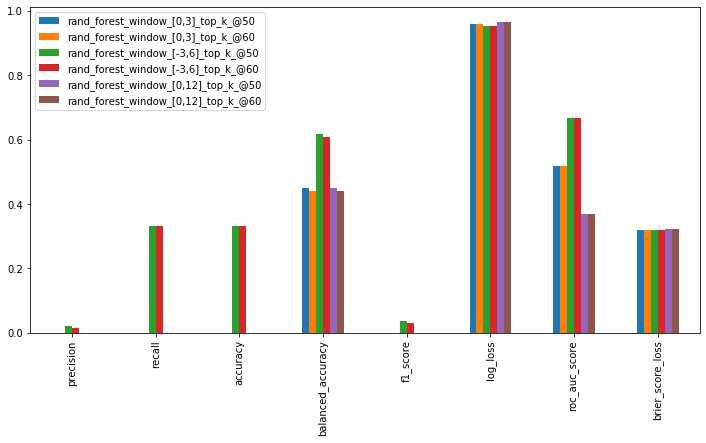

Number of Experimental Samples:  500


,"xg_boost_window_[0,3]_top_k_@50","xg_boost_window_[0,3]_top_k_@60","xg_boost_window_[-3,6]_top_k_@50","xg_boost_window_[-3,6]_top_k_@60","xg_boost_window_[0,12]_top_k_@50","xg_boost_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
recall,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
accuracy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
balanced_accuracy,0.44980,0.43976,0.44970,0.43964,0.44949,0.43939
f1_score,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
log_loss,1.01932,1.01932,1.02206,1.02206,1.02371,1.02371
roc_auc_score,0.41767,0.41767,0.34742,0.34742,0.38061,0.38061
brier_score_loss,0.33835,0.33835,0.33954,0.33954,0.33999,0.33999


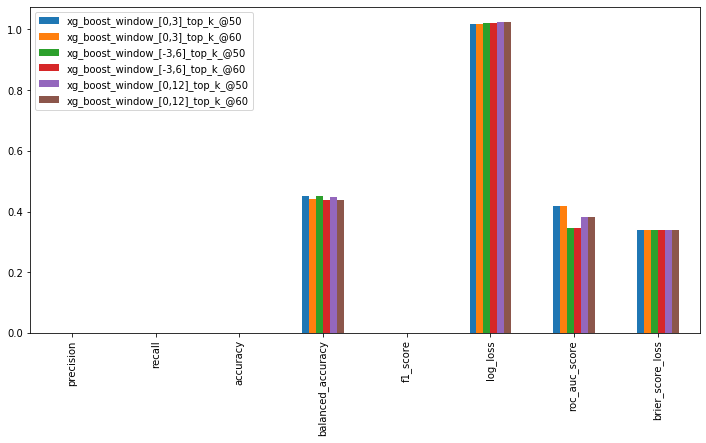

Number of Experimental Samples:  500


,"sgmm_window_[0,3]_top_k_@50","sgmm_window_[0,3]_top_k_@60","sgmm_window_[-3,6]_top_k_@50","sgmm_window_[-3,6]_top_k_@60","sgmm_window_[0,12]_top_k_@50","sgmm_window_[0,12]_top_k_@60"
precision,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
recall,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
accuracy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
balanced_accuracy,0.44980,0.43976,0.44970,0.43964,0.44949,0.43939
f1_score,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
log_loss,0.97518,0.97518,0.97499,0.97499,0.97476,0.97476
roc_auc_score,0.48494,0.48494,0.50369,0.50369,0.50990,0.50990
brier_score_loss,0.32498,0.32498,0.32489,0.32489,0.32475,0.32475


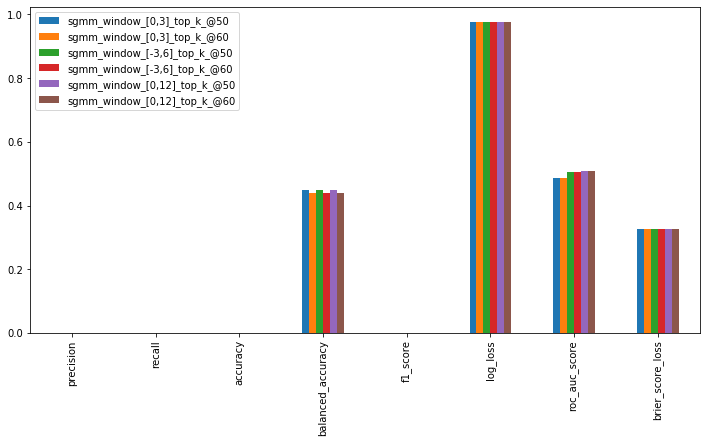

Number of Experimental Samples:  500


In [182]:
#pd.set_option('display.max_rows', None)
if __name__ == "__main__":
    c_p, c_r, c_e = load_configurations()
    #generate_synthetic_ground_truth_data(c_p, c_r)
    #generate_synthetic_prediction_data(c_p)
    all_model_evaluations = evaluate(c_p, c_r, c_e)
    
    #keep visual=True if you want to see data + plots
    #keep save=True if you want to save the data into a CSV file
    present_evaluation(c_e, all_model_evaluations, visual=True, save=True) 
    